In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

from time_series_influences.utils import split_time_series, match_train_time_block_index
from time_series_influences.influence_functions import compute_loo_linear_approx
from time_series_influences.anomaly_detection import scale_influence_functions, eval_anomaly_detector

seed = 666
np.random.seed(seed)

#### point outlier detection

In [2]:
data_dir = Path("../ucr_time_series_anomaly_datasets/data")
file_name = "037_UCR_Anomaly_DISTORTEDLab2Cmac011215EPG1_5000_17210_17260.txt"
ts = pd.read_csv(data_dir/file_name, delimiter='\t', header=None).to_numpy()
ts = ts.squeeze()
anomaly_start, anomaly_end = 17210, 17260
ground_truth = np.zeros_like(ts)
ground_truth[anomaly_start:anomaly_end] = 1.

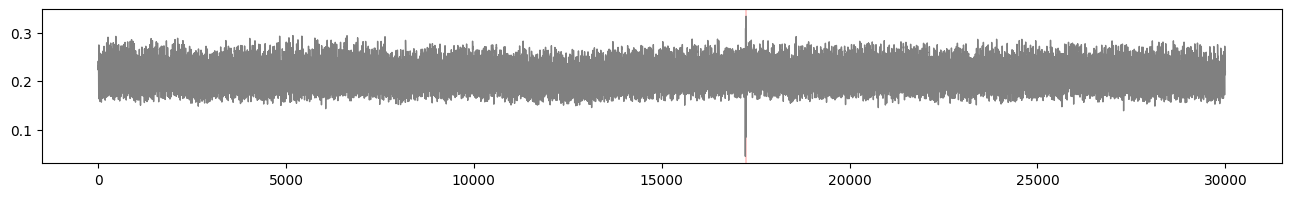

In [3]:
plt.figure(figsize=(16,2))
plt.plot(ts, c="gray", linewidth=1)
plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)
plt.show()

In [4]:
block_length = 50
X_train, Y_train = split_time_series(ts, block_length=block_length)
matched_block_idxs = match_train_time_block_index(ts, X_train)
print(X_train.shape, Y_train.shape)

(29951, 50) (29951,)


In [5]:
lr = LinearRegression().fit(X_train, Y_train)
beta = lr.coef_
b = lr.intercept_
inv_hess = len(X_train) * np.linalg.inv(X_train.T @ X_train)
params = (beta, b, inv_hess)

In [6]:
# compute IF for each time block
time_block_loos = []
for i in tqdm(range(len(X_train)), total=len(X_train), desc="Compute LOO"):
  time_block_loos.append(compute_loo_linear_approx(i, i, X_train, Y_train, X_train, Y_train, params))
time_block_loos = np.array(time_block_loos)

Compute LOO: 100%|█████████████████████| 29951/29951 [00:00<00:00, 87334.44it/s]


In [7]:
# compute IF for each time point
time_point_loos = []
for i in range(len(matched_block_idxs)):
  time_point_loos.append((time_block_loos[matched_block_idxs[i]]).mean())
time_point_loos = np.array(time_point_loos)

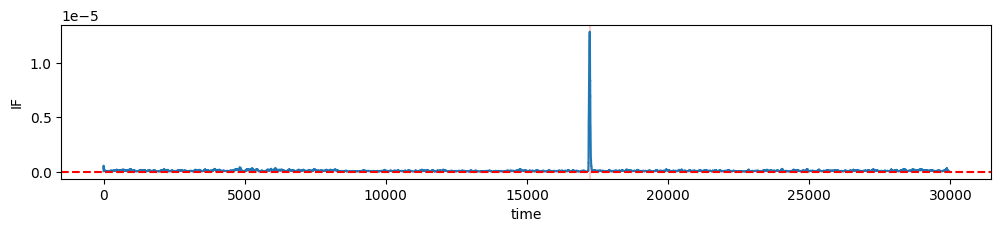

In [8]:
plt.figure(figsize=(12,2))
loos_viz = np.ones_like(ts) * np.nan
loos_viz[:len(X_train)] = time_point_loos
plt.plot(loos_viz)
plt.axhline(y=0, c="r", linestyle="--")
plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)
plt.ylabel("IF")
plt.xlabel("time")
plt.show()

In [9]:
anomaly_scores = scale_influence_functions(time_point_loos, block_length=block_length)

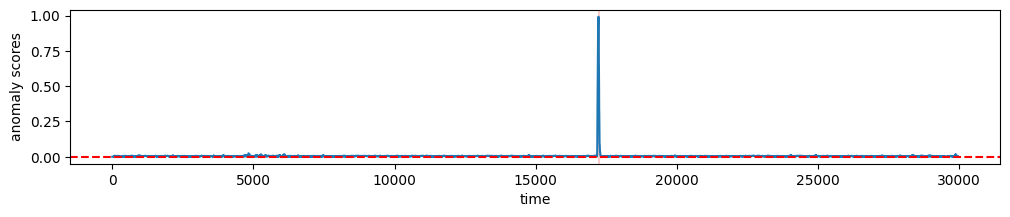

In [10]:
plt.figure(figsize=(12,2))
loos_viz = np.ones_like(ts) * np.nan
loos_viz[:len(X_train)] = anomaly_scores
plt.plot(loos_viz)
plt.axhline(y=0, c="r", linestyle="--")
plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)
plt.ylabel("anomaly scores")
plt.xlabel("time")
plt.show()

In [11]:
contam_ratio = block_length / len(ts)
detected_outliers = np.zeros_like(ts)
# TO DO: why is there a time lag?
detected_outliers[block_length//3:block_length//3 + len(anomaly_scores)] = anomaly_scores > np.quantile(anomaly_scores, 1-contam_ratio)

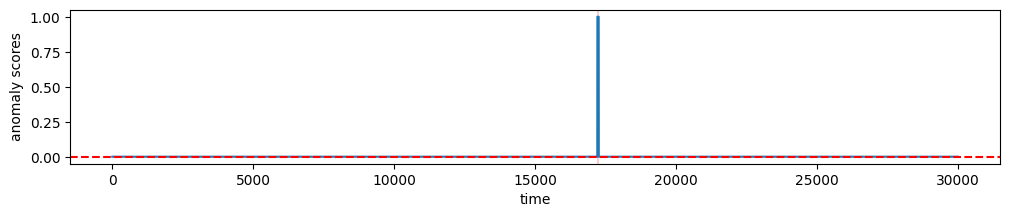

In [12]:
plt.figure(figsize=(12,2))
loos_viz = np.ones_like(ts) * np.nan
loos_viz[:len(detected_outliers)] = detected_outliers
plt.plot(loos_viz)
plt.axhline(y=0, c="r", linestyle="--")
plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)
plt.ylabel("anomaly scores")
plt.xlabel("time")
plt.show()

In [13]:
prec, rec, f1 = eval_anomaly_detector(ground_truth[:len(detected_outliers)], detected_outliers)

precision: 1.000 recall: 1.000 F1: 1.000


#### change point detection

In [14]:
data_dir = Path("../ucr_time_series_anomaly_datasets/data")
file_name = "042_UCR_Anomaly_DISTORTEDLab2Cmac011215EPG6_7000_12190_12420.txt"
ts = pd.read_csv(data_dir/file_name, delimiter='\t', header=None).to_numpy()
ts = ts.squeeze()
anomaly_start, anomaly_end = 12190, 12420
ground_truth = np.zeros_like(ts)
ground_truth[anomaly_start:anomaly_end] = 1.

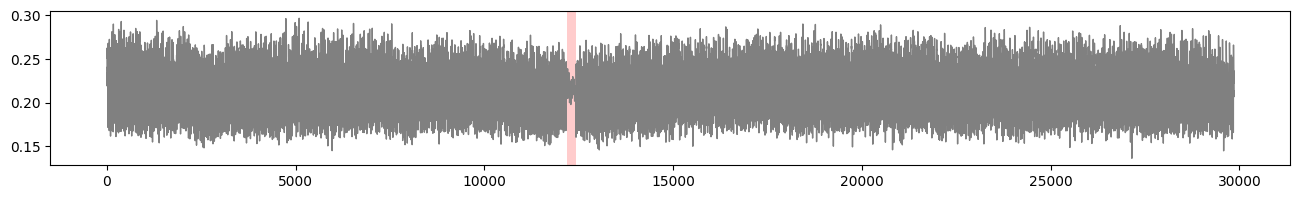

In [15]:
plt.figure(figsize=(16,2))
plt.plot(ts, c="gray", linewidth=1)
plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)
plt.show()

In [16]:
block_length = 200
X_train, Y_train = split_time_series(ts, block_length=block_length)
matched_block_idxs = match_train_time_block_index(ts, X_train)
print(X_train.shape, Y_train.shape)

(29659, 200) (29659,)


In [17]:
lr = LinearRegression().fit(X_train, Y_train)
beta = lr.coef_
b = lr.intercept_
inv_hess = len(X_train) * np.linalg.inv(X_train.T @ X_train)
params = (beta, b, inv_hess)

In [18]:
# compute IF for each time block
time_block_loos = []
for i in tqdm(range(len(X_train)), total=len(X_train), desc="Compute LOO"):
  time_block_loos.append(compute_loo_linear_approx(i, i, X_train, Y_train, X_train, Y_train, params))
time_block_loos = np.array(time_block_loos)

Compute LOO: 100%|█████████████████████| 29659/29659 [00:01<00:00, 19667.85it/s]


In [19]:
# compute IF for each time point
time_point_loos = []
for i in range(len(matched_block_idxs)):
  time_point_loos.append((time_block_loos[matched_block_idxs[i]]).mean())
time_point_loos = np.array(time_point_loos)

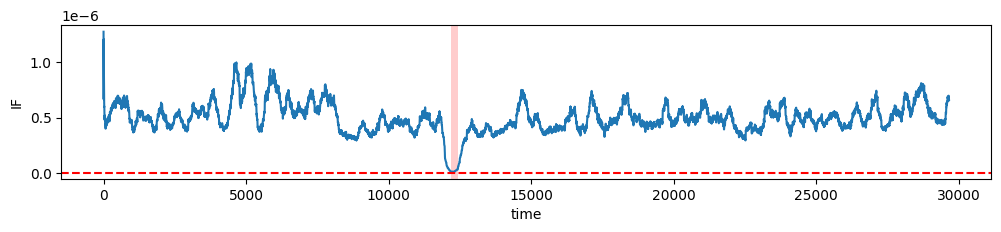

In [20]:
plt.figure(figsize=(12,2))
loos_viz = np.ones_like(ts) * np.nan
loos_viz[:len(X_train)] = time_point_loos
plt.plot(loos_viz)
plt.axhline(y=0, c="r", linestyle="--")
plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)
plt.ylabel("IF")
plt.xlabel("time")
plt.show()

In [21]:
anomaly_scores = scale_influence_functions(time_point_loos, block_length)

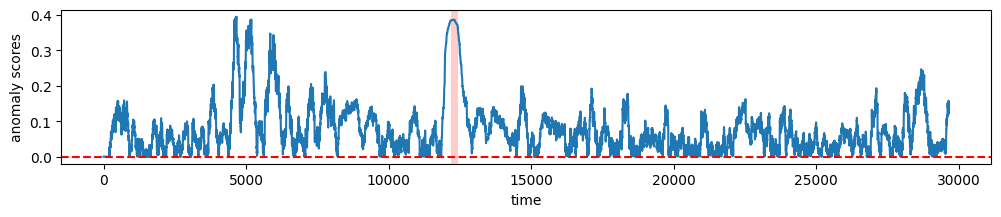

In [22]:
plt.figure(figsize=(12,2))
loos_viz = np.ones_like(ts) * np.nan
loos_viz[:len(X_train)] = anomaly_scores
plt.plot(loos_viz)
plt.axhline(y=0, c="r", linestyle="--")
plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)
plt.ylabel("anomaly scores")
plt.xlabel("time")
plt.show()

In [23]:
contam_ratio = block_length / len(ts)
detected_outliers = np.zeros_like(ts)
# TO DO: why is there a time lag?
detected_outliers[block_length//3:block_length//3 + len(anomaly_scores)] = anomaly_scores > np.quantile(anomaly_scores, 1-contam_ratio)

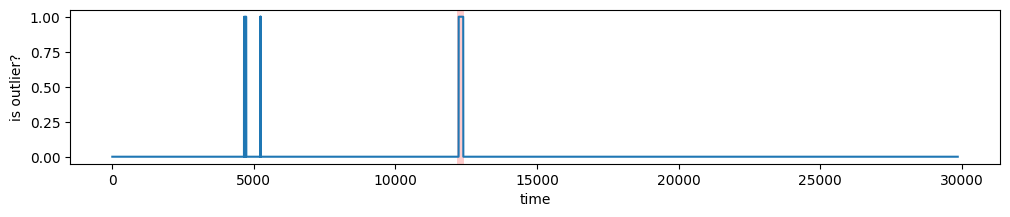

In [24]:
plt.figure(figsize=(12,2))
loos_viz = np.ones_like(ts) * np.nan
loos_viz[:len(detected_outliers)] = detected_outliers
plt.plot(loos_viz)
plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)
plt.ylabel("is outlier?")
plt.xlabel("time")
plt.show()

In [25]:
prec, rec, f1 = eval_anomaly_detector(ground_truth[:len(detected_outliers)], detected_outliers)

precision: 0.824 recall: 0.713 F1: 0.765


#### anomaly pattern detection

In [26]:
data_dir = Path("../ucr_time_series_anomaly_datasets/data")
file_name = "062_UCR_Anomaly_DISTORTEDgaitHunt1_18500_33070_33180.txt"
ts = pd.read_csv(data_dir/file_name, delimiter='\t', header=None).to_numpy()
ts = ts.squeeze()
anomaly_start, anomaly_end = 33070, 33180
ground_truth = np.zeros_like(ts)
ground_truth[anomaly_start:anomaly_end] = 1.

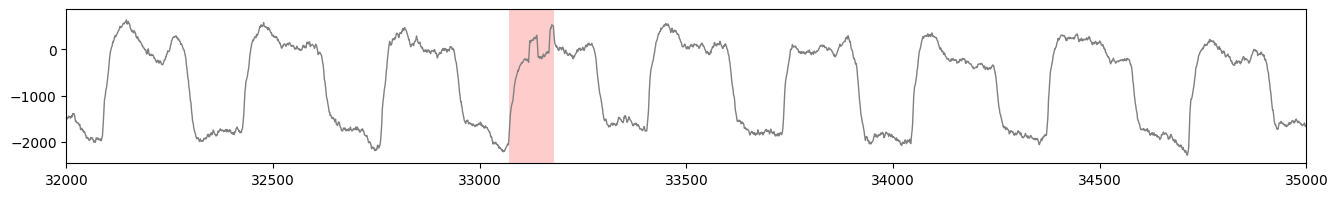

In [27]:
plt.figure(figsize=(16,2))
plt.plot(ts, c="gray", linewidth=1)
plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)
plt.xlim(32000, 35000)
plt.show()

In [28]:
block_length = 100
X_train, Y_train = split_time_series(ts, block_length=block_length)
matched_block_idxs = match_train_time_block_index(ts, X_train)
print(X_train.shape, Y_train.shape)

(63900, 100) (63900,)


In [29]:
lr = LinearRegression().fit(X_train, Y_train)
beta = lr.coef_
b = lr.intercept_
inv_hess = len(X_train) * np.linalg.inv(X_train.T @ X_train)
params = (beta, b, inv_hess)

In [30]:
# compute IF for each time block
time_block_loos = []
for i in tqdm(range(len(X_train)), total=len(X_train), desc="Compute LOO"):
  time_block_loos.append(compute_loo_linear_approx(i, i, X_train, Y_train, X_train, Y_train, params))
time_block_loos = np.array(time_block_loos)

Compute LOO: 100%|█████████████████████| 63900/63900 [00:02<00:00, 27715.42it/s]


In [31]:
# compute IF for each time point
time_point_loos = []
for i in range(len(matched_block_idxs)):
  time_point_loos.append((time_block_loos[matched_block_idxs[i]]).mean())
time_point_loos = np.array(time_point_loos)

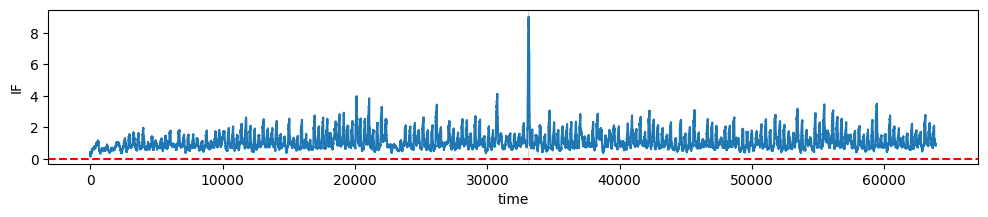

In [32]:
plt.figure(figsize=(12,2))
loos_viz = np.ones_like(ts) * np.nan
loos_viz[:len(X_train)] = time_point_loos
plt.plot(loos_viz)
plt.axhline(y=0, c="r", linestyle="--")
plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)
plt.ylabel("IF")
plt.xlabel("time")
plt.show()

In [33]:
anomaly_scores = scale_influence_functions(time_point_loos, block_length)

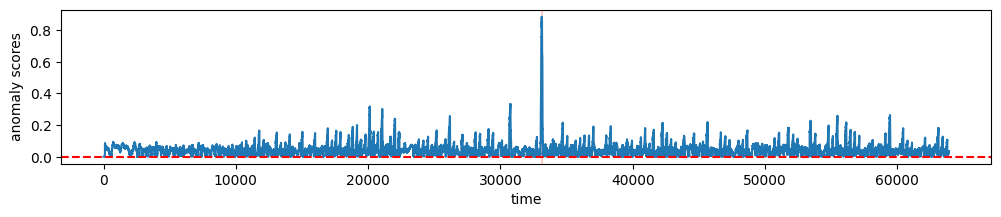

In [34]:
plt.figure(figsize=(12,2))
loos_viz = np.ones_like(ts) * np.nan
loos_viz[:len(X_train)] = anomaly_scores
plt.plot(loos_viz)
plt.axhline(y=0, c="r", linestyle="--")
plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)
plt.ylabel("anomaly scores")
plt.xlabel("time")
plt.show()

In [35]:
contam_ratio = block_length / len(ts)
detected_outliers = np.zeros_like(ts)
# TO DO: why is there a time lag?
detected_outliers[block_length//3:block_length//3 + len(anomaly_scores)] = anomaly_scores > np.quantile(anomaly_scores, 1-contam_ratio)

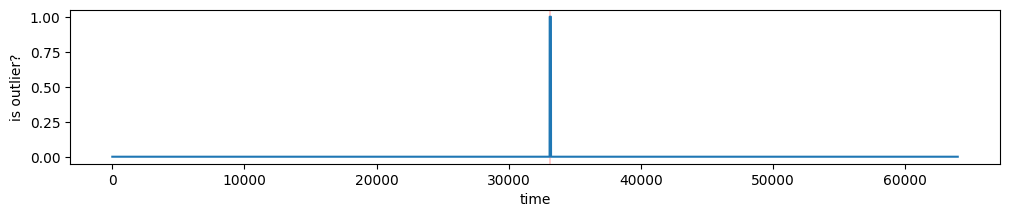

In [36]:
plt.figure(figsize=(12,2))
loos_viz = np.ones_like(ts) * np.nan
loos_viz[:len(detected_outliers)] = detected_outliers
plt.plot(loos_viz)
plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)
plt.ylabel("is outlier?")
plt.xlabel("time")
plt.show()

In [37]:
prec, rec, f1 = eval_anomaly_detector(ground_truth[:len(detected_outliers)], detected_outliers)

precision: 0.770 recall: 0.700 F1: 0.733


#### noise detection

In [38]:
data_dir = Path("../ucr_time_series_anomaly_datasets/data")
file_name = "003_UCR_Anomaly_DISTORTED3sddb40_35000_46600_46900.txt"
ts = pd.read_csv(data_dir/file_name, delimiter='\t', header=None).to_numpy()
ts = ts.squeeze()
anomaly_start, anomaly_end = 46600, 46900
ground_truth = np.zeros_like(ts)
ground_truth[anomaly_start:anomaly_end] = 1.

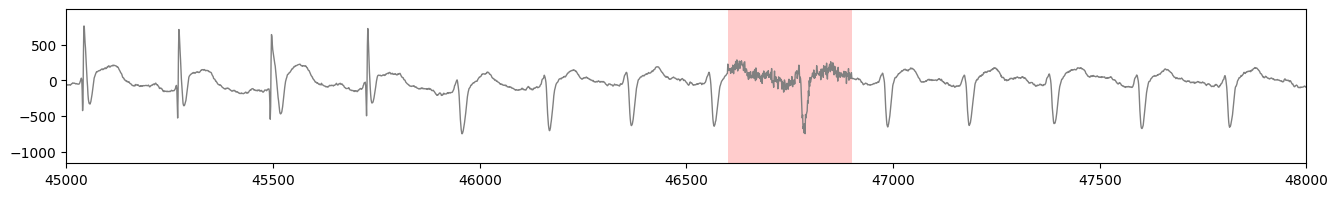

In [39]:
plt.figure(figsize=(16,2))
plt.plot(ts, c="gray", linewidth=1)
plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)
plt.xlim(45000, 48000)
plt.show()

In [40]:
block_length = 300
X_train, Y_train = split_time_series(ts, block_length=block_length)
matched_block_idxs = match_train_time_block_index(ts, X_train)
print(X_train.shape, Y_train.shape)

(79700, 300) (79700,)


In [41]:
lr = LinearRegression().fit(X_train, Y_train)
beta = lr.coef_
b = lr.intercept_
inv_hess = len(X_train) * np.linalg.inv(X_train.T @ X_train)
params = (beta, b, inv_hess)

In [42]:
# compute IF for each time block
time_block_loos = []
for i in tqdm(range(len(X_train)), total=len(X_train), desc="Compute LOO"):
  time_block_loos.append(compute_loo_linear_approx(i, i, X_train, Y_train, X_train, Y_train, params))
time_block_loos = np.array(time_block_loos)

Compute LOO: 100%|█████████████████████| 79700/79700 [00:07<00:00, 11347.63it/s]


In [43]:
# compute IF for each time point
time_point_loos = []
for i in range(len(matched_block_idxs)):
  time_point_loos.append((time_block_loos[matched_block_idxs[i]]).mean())
time_point_loos = np.array(time_point_loos)

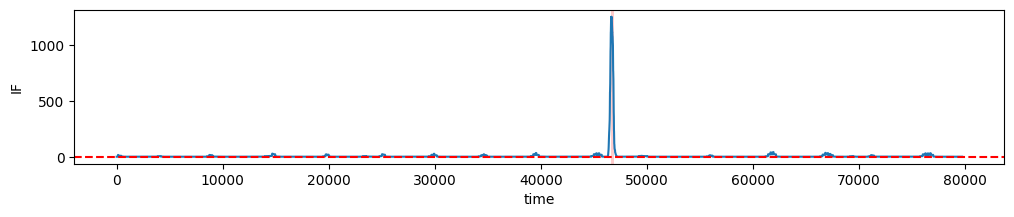

In [44]:
plt.figure(figsize=(12,2))
loos_viz = np.ones_like(ts) * np.nan
loos_viz[:len(X_train)] = time_point_loos
plt.plot(loos_viz)
plt.axhline(y=0, c="r", linestyle="--")
plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)
plt.ylabel("IF")
plt.xlabel("time")
plt.show()

In [45]:
anomaly_scores = scale_influence_functions(time_point_loos, block_length)

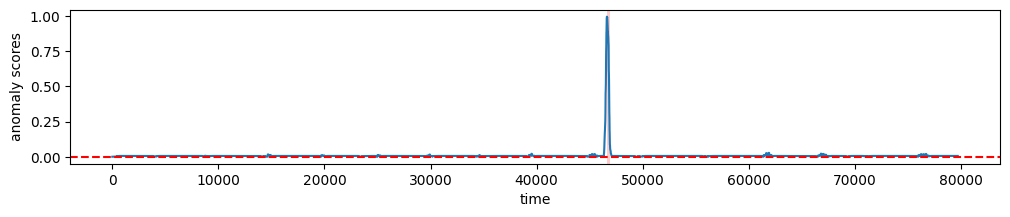

In [46]:
plt.figure(figsize=(12,2))
loos_viz = np.ones_like(ts) * np.nan
loos_viz[:len(X_train)] = anomaly_scores
plt.plot(loos_viz)
plt.axhline(y=0, c="r", linestyle="--")
plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)
plt.ylabel("anomaly scores")
plt.xlabel("time")
plt.show()

In [47]:
contam_ratio = block_length / len(ts)
detected_outliers = np.zeros_like(ts)
# TO DO: why is there a time lag?
detected_outliers[block_length//3:block_length//3 + len(anomaly_scores)] = anomaly_scores > np.quantile(anomaly_scores, 1-contam_ratio)

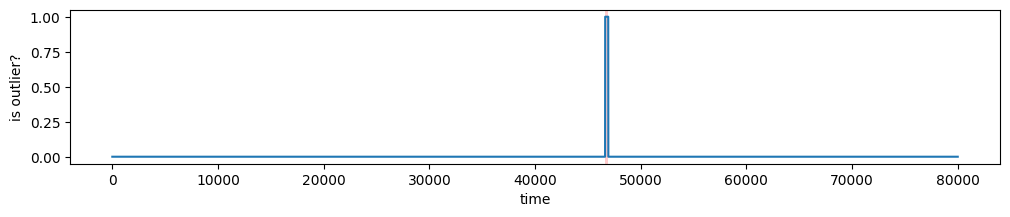

In [48]:
plt.figure(figsize=(12,2))
loos_viz = np.ones_like(ts) * np.nan
loos_viz[:len(detected_outliers)] = detected_outliers
plt.plot(loos_viz)
plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)
plt.ylabel("is outlier?")
plt.xlabel("time")
plt.show()

In [49]:
prec, rec, f1 = eval_anomaly_detector(ground_truth[:len(detected_outliers)], detected_outliers)

precision: 0.910 recall: 0.907 F1: 0.908
